# Mandelbrot set with metalcompute

This notebook shows how to quickly calculate images of the mandelbrot set using metalcompute (on macOS)

It uses three libraries, which need to be installed using pip: metalcompute, numpy, pillow & IPython

In [1]:
import metalcompute as mc
import numpy as np
from PIL.Image import frombuffer
import IPython

This opens the GPU for use with metalcompute

In [2]:
dev = mc.Device()

Next we define the metal kernel to compute the mandelbrot set at a given position and resolution

In [3]:
def mandelbrot_kernel():
    return """
#include <metal_stdlib>
using namespace metal;

kernel void mandelbrot(const device float *uniform [[ buffer(0) ]],
                device uchar4 *out [[ buffer(1) ]],
                uint id [[ thread_position_in_grid ]]) {
    float width = uniform[0];
    float height = uniform[1];
    float maxiter = uniform[2];
    float2 c_mid = float2(uniform[3], uniform[4]);
    float scale = uniform[5];

    // Calculate which pixel this is
    float2 middle = float2(width*0.5, height*0.5);
    float2 pos = float2(id % int(width), id / int(width)) - middle;
    float min_side = min(width, height);

    // Complex coordinate of this pixel offset by cx, cy and scaled by scale
    float2 c = scale * (pos / min_side) + c_mid;

    float2 z = c;
    float done = 0.0, steps = 1.0, az = 0.0;
    
    // Main computation
    for (int iter = maxiter; iter>0; iter--) {
        z = float2((z.x * z.x) - (z.y * z.y) + c.x, (2.0 * z.x * z.y) + c.y);
        az = ((z.x*z.x) + (z.y*z.y));
        done = az >= 4.0 ? 1.0 : 0.0;
        if (done > 0.0) { break; }
        steps += 1.0;
    }

    // Pick suitable colour for the result
    z = float2((z.x * z.x) - (z.y * z.y) + c.x, (2.0 * z.x * z.y) + c.y);
    z = float2((z.x * z.x) - (z.y * z.y) + c.x, (2.0 * z.x * z.y) + c.y);
    az = ((z.x*z.x) + (z.y*z.y));
    steps += 2.0;
    steps -= log(log(sqrt(az)))/log(2.0);
    float p = 3.14159265358979323846264 * steps/256.0;
    float3 col = float3(0.5+0.5*sin(p*13.0),
                        0.5+0.5*sin(p*17.0),
                        0.5+0.5*sin(p*19.0));
    if (steps >= maxiter) col *= 0.0; // Outside set
    out[id] = uchar4(uchar3(col*255.),255);
}
"""
    

Next we compile the mandelbrot kernel to a funtion we can call

In [4]:
mb_kern = mandelbrot_kernel()
mandelbrot_fn = dev.kernel(mb_kern).function("mandelbrot")

Now we choose an image resolution, number of iterations to calculate, and allocate memory for the image

In [5]:
width, height = 240, 180
iters = 4096
image = dev.buffer(width*height*4)

First, we render an initial full view of the set

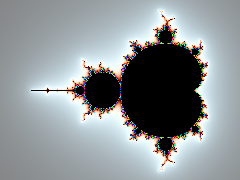

In [6]:
x = -0.75
y = 0.0
scale = 2.5
mandelbrot_fn(width*height, np.array([width, height, iters, x, y, scale], dtype='f'), image)
frombuffer("RGBA",(width, height), data=image)

Next we can zoom in on a mini-mandelbrot (note the shifted x coord, and much smaller scale value)

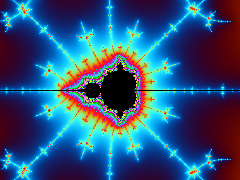

In [7]:
x = -1.7111
y = 0.0
scale = 0.001
mandelbrot_fn(width*height, np.array([width, height, iters, x, y, scale], dtype='f'), image)
frombuffer("RGBA",(width, height), data=image)

If you have ffmpeg installed (from homebrew) you can also quickly render & view videos

In [ ]:
import subprocess

def encode_to_video(dev, render_fn, frames, width=240, height=180, filename="out.mp4", bitrate="5000k"):
    args = f"ffmpeg -f rawvideo -pix_fmt bgr32 -s {width}x{height} -r 30 -color_range 2 -i - -y -vcodec h264_videotoolbox -b:v {bitrate} -f mp4 -movflags faststart {filename}".split(" ")
    encoder = subprocess.Popen(args,stdin=subprocess.PIPE,stderr=subprocess.DEVNULL)
    buffers = []
    for i in range(1,frames):
        new_image, new_handle = render_fn(dev, i, frames, width, height)
        buffers.append((new_image, new_handle))
        del new_image
        del new_handle

        if len(buffers)>3:
            write_image, write_handle = buffers.pop(0)
            del write_handle # Will block until rendered
            encoder.stdin.write(write_image)

    while len(buffers)>0:
        write_image, write_handle = buffers.pop(0)
        del write_handle # Will block until rendered
        encoder.stdin.write(write_image)

    encoder.stdin.close()
    encoder.wait()
    

In [ ]:
def zoom(dev, frame, frames, width, height):
    iters = 4096
    x = -1.7111
    y = -0.00245
    scale = 4.0*(0.99**(frames-frame))
    new_image = dev.buffer(width*height*4)
    new_handle = mandelbrot_fn(width*height, np.array([width, height, iters, x, y, scale], dtype='f'), new_image)
    return new_image, new_handle

encode_to_video(dev, zoom, frames=1000, width=1024, height=1024, filename="out.mp4", bitrate="2500k")
IPython.display.Video("out.mp4")